# Exercise 9 | Nonlinear Model Predictive Control

Consider a slot car racing track described by the 2D curve $(x(\lambda),y(\lambda))\in\mathbb{R}^2$ parametrized by the progress variable $\lambda\in\mathbb{R}$. The position of the car is entirely determined by $\lambda$ and its velocity by $v=\dot{\lambda}$, allowing us to model it using the state $x=(\lambda, v)$.

The curvature of the track is given by a function $\kappa(\lambda)$ and the car is know to flip out from the track if the speed $v$ exceeds $\frac{1}{1+\kappa(\lambda)}$.

The car actuation can be modeled using an acceleration input $a$ and a braking input $b$, making up the control vector $u=(a,b)$.

The dynamics of the car can then be written as
$$
\begin{align*}
    \dot{\lambda} & = v, \\
    \dot{v} & = 5a - 6.6 b v - 0.01 v^3,
\end{align*}
$$
where the cubic term corresponds to a viscous friction coming from the track surface and air resistance.
We will denote this continuous-time dynamics as $\dot{x} = f(x,u)$.

Your goal in this notebook will be to implement a Nonlinear Model Predictive Control (NMPC) scheme to control the car around the track while avoiding flipping out.

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ipywidgets import interact

np.random.seed(0)

## Problem 1: Discretization of the dynamics

Recall that for a given initial time $t_0$ and an integration step $h$, the state at time $t_0+h$ is given by $$ x(t_0+h) = \int_{0}^{h} f(x(t_0+s),u(t_0+s)) ds. $$

There are several methods for aproximating this integration for a constant input (i.e. when $u(t_0+s) = u(t_0)$ for all $s\in[0,h]$), like Euler and Runge-Kutta methods.

### Task 1
Implement Euler and 4th order Runge-Kutta (RK4) discretization methods to define the discrete-time dynamics $ x_{k+1} = f_d(x_k,u_k) $.
Test your integrators with the initial conditions $x(t_0) = (0, 0.5), u(t_0) = (0.0, 0.2)$.

In [2]:
def f(x, u):
    return np.array([x[1], 5 * u[0] - 6.6 * u[1] * x[1] - 0.01 * x[0] ** 3])


def euler(f, x, u, h):
    # TODO: ------------------
	# TODO: add your code here
    x_next = x + h*f(x, u)
    return x_next
	# TODO: ------------------


def rk4(f, x, u, h):
    # TODO: ------------------
	# TODO: add your code here
    k1 = f(x, u)
    k2 = f(x + h/2*k1, u)
    k3 = f(x + h/2*k2, u)
    k4 = f(x + h*k3, u)
    x_next = x + h*(k1/6 + k2/3 + k3/3 + k4/6)
    return x_next
    # TODO: ------------------

In [3]:
x0 = np.array([0.0, 0.5])
u0 = np.array([0.0, 0.2])
h = 0.01
print("The next state computed from Euler integrator is: ", euler(f, x0, u0, h))
print("The next state computed from RK4 integrator is: ", rk4(f, x0, u0, h))

The next state computed from Euler integrator is:  [0.005  0.4934]
The next state computed from RK4 integrator is:  [0.00496714 0.49344337]


### Task 2
For $x(0)=(0,0.5)$ and $u(t)=(0,0.2)$, simulate the system for 10 seconds with both integrators for $h=0.1s$ and $h=0.5s$.
Plot and compare the resulting trajectories with the ones given by the `ode45` integrator defined for you below.

In [4]:
def ode45(f, x, u, h):
    return solve_ivp(lambda t, x: f(x, u), [0, h], x, method='RK45').y[:, -1]

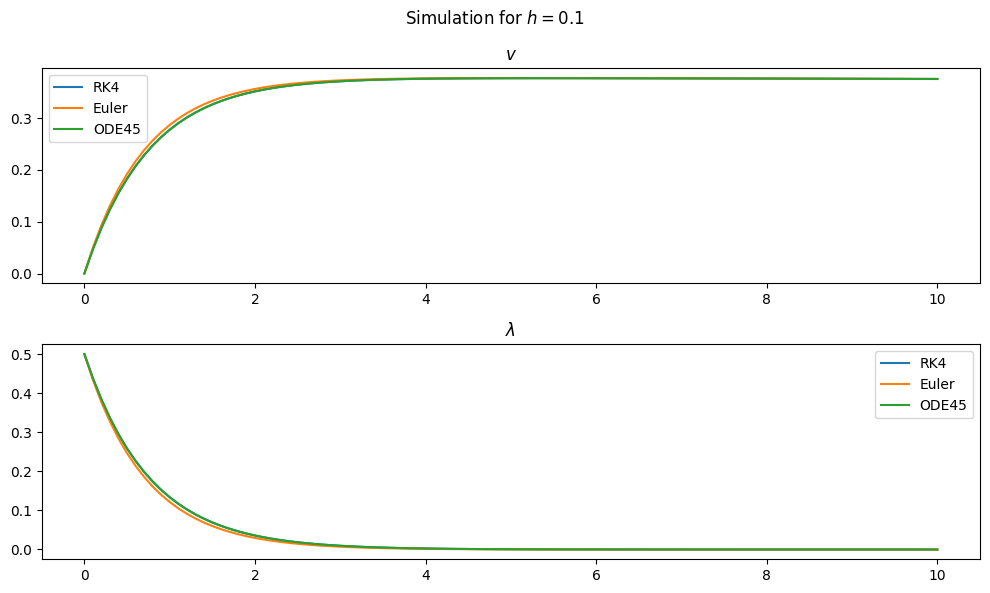

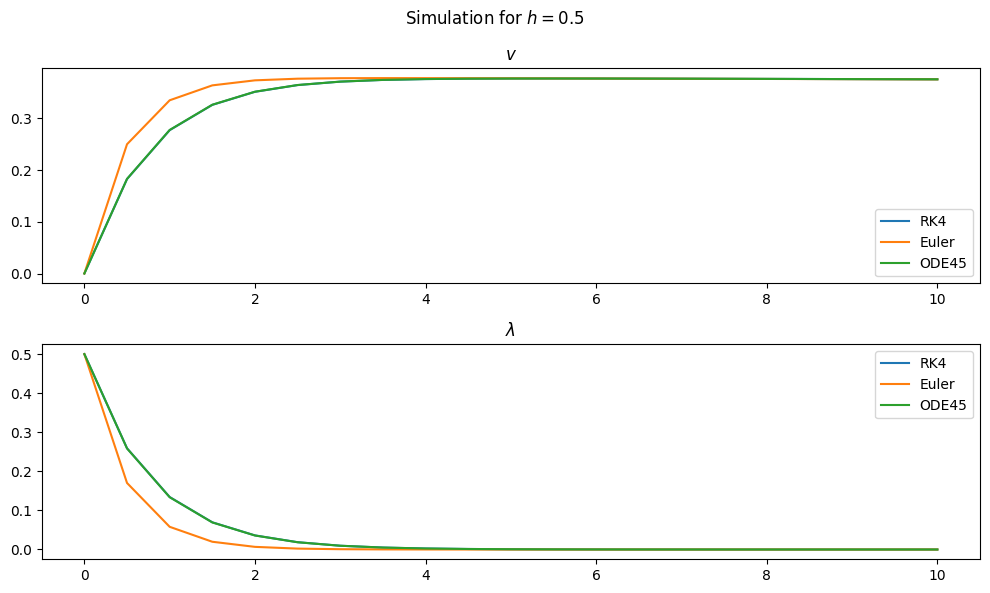

In [5]:
x0 = np.array([0.0, 0.5])
u0 = np.array([0.0, 0.2])
Tsim = 10
for h in [0.1, 0.5]:
    Nsim = int(Tsim / h)
    x_euler = np.zeros((Nsim + 1, 2))
    x_euler[0] = x0
    x_rk4 = np.zeros((Nsim + 1, 2))
    x_rk4[0] = x0
    x_ode45 = np.zeros((Nsim + 1, 2))
    x_ode45[0] = x0
    t = np.linspace(0, Tsim, Nsim + 1)
    for i in range(Nsim):
        # TODO: -------------------------------------
        # TODO: simulate one step with each integrator
        x_rk4[i + 1] = rk4(f, x_rk4[i], u0, h)
        x_euler[i + 1] = euler(f, x_euler[i], u0, h)
        x_ode45[i + 1] = ode45(f, x_ode45[i], u0, h)
        # TODO: -------------------------------------

    plt.figure(figsize=(10, 6))
    plt.suptitle(rf"Simulation for $h = {h}$")

    plt.subplot(2, 1, 1)
    plt.title(r"$v$")
    plt.plot(t, x_rk4[:, 0], label="RK4")
    plt.plot(t, x_euler[:, 0], label="Euler")
    plt.plot(t, x_ode45[:, 0], label="ODE45")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title(r"$\lambda$")
    plt.plot(t, x_rk4[:, 1], label="RK4")
    plt.plot(t, x_euler[:, 1], label="Euler")
    plt.plot(t, x_ode45[:, 1], label="ODE45")
    plt.legend()

    plt.tight_layout()

plt.show()

## Problem 2: Compute jacobians with CasADi

To implement the NMPC controller in the following problem, you will need a way to compute the derivatives used in the optimization algorithm.

To avoid deriving the formulae by hand, we will use [CasADi](https://web.casadi.org/), a library that allows you to define symbolic expressions and compute their derivatives using algorithmic differentiation.

We highly recommend reading the [CasADi documentation](https://web.casadi.org/docs/), in particular: 
- [section 3.1](https://web.casadi.org/docs/#the-sx-symbolics) describing the main symbolic type you will use (`ca.SX`)
- [section 3.6](https://web.casadi.org/docs/#arithmetic-operations) and [3.7](https://web.casadi.org/docs/#querying-properties) describing the main operations you will use on them
- [section 3.9](https://web.casadi.org/docs/#calculus-algorithmic-differentiation) describing how to perform algorithmic differentiation to compute derivatives of functions
- [section 4-4.1](https://web.casadi.org/docs/#document-function) describing how to wrap your expressions into callable functions

If you have a doubt about how a certain function works, either try to find an example in the previous page, or look for it in the [CasADi API reference](https://web.casadi.org/python-api/).

### Task 1

Your goal is to compute the jacobians of the continuous dynamics $f$ with respect to the state and input:
$$ \frac{\partial f}{\partial x} \quad \text{and} \quad \frac{\partial f}{\partial u}. $$

Implement two versions for each: 
- one using a finite difference approximation,
- one using CasADi's algorithmic differentiation capabilities.

Compare the errors between the two at the points $x=(0, 0.5), u=(0,0.2)$.

**Hints**:

- Recall that the finite difference approximation for the Jacobian is given by
	$$ \frac{\partial f}{\partial x} \approx \frac{f(x + \epsilon, u) - f(x - \epsilon, u)}{2 \epsilon}, $$

	and you can use a small value for $\epsilon$, e.g. $10^{-6}$.

- For the CasADi implementation, you will need to define symbolic variables for the states and inputs using `ca.SX.sym`, define the discrete dynamics using these symbolic variables, use `ca.jacobian` function to compute the derivatives, and wrap the resulting expressions into a `ca.Function` to evaluate them numerically.

- You can call a `ca.Function` on a `np.ndarray`, but the result will be a special CasADi type `ca.DM` (corresponding to a 'Data Matrix', see [documentation Section 3.2](https://web.casadi.org/docs/#dm)) that you can convert to a `np.ndarray` using the `.toarray()` method.

In [6]:
# TODO: ---------------------------------------------------------
eps = 1e-6

# HOW I WOULD HAVE COMPUTED THE JACOBIANS BASED ON WHAT IS ASKED : COMPUTE JACOBIANS OF !discretized! DYNAMICS -> question on ED

def jac_x_fd(x,u): 
	# TODO: implement the finite difference Jacobian here
    df1dx1 = (rk4(f, [x[0]+eps, x[1]], u, h)[0] - rk4(f, [x[0]-eps, x[1]], u, h)[0])/(2*eps)
    df1dx2 = (rk4(f, [x[0], x[1]+eps], u, h)[0] - rk4(f, [x[0], x[1]-eps], u, h)[0])/(2*eps)
    df2dx1 = (rk4(f, [x[0]+eps, x[1]], u, h)[1] - rk4(f, [x[0]-eps, x[1]], u, h)[1])/(2*eps)
    df2dx2 = (rk4(f, [x[0], x[1]+eps], u, h)[1] - rk4(f, [x[0], x[1]-eps], u, h)[1])/(2*eps)
    return np.array([[df1dx1, df1dx2], [df2dx1, df2dx2]])

def jac_u_fd(x,u):
	# TODO: implement the finite difference Jacobian here
    df1du1 = (rk4(f, x, [u[0]+eps, u[1]], h)[0] - rk4(f, x, [u[0]-eps, u[1]], h)[0])/(2*eps)
    df1du2 = (rk4(f, x, [u[0], u[1]+eps], h)[0] - rk4(f, x, [u[0], u[1]-eps], h)[0])/(2*eps)
    df2du1 = (rk4(f, x, [u[0]+eps, u[1]], h)[1] - rk4(f, x, [u[0]-eps, u[1]], h)[1])/(2*eps)
    df2du2 = (rk4(f, x, [u[0], u[1]+eps], h)[1] - rk4(f, x, [u[0], u[1]-eps], h)[1])/(2*eps)
    return np.array([[df1du1, df1du2 ], [df2du1, df2du2]])

#SOLUTIONS :
# def jac_x_fd(x,u): 
# 	# TODO: implement the finite difference Jacobian here
#     df1dx1 = (f([x[0]+eps, x[1]], u)[0] - f([x[0]-eps, x[1]], u)[0])/(2*eps)
#     df1dx2 = (f([x[0], x[1]+eps], u)[0] - f([x[0], x[1]-eps], u)[0])/(2*eps)
#     df2dx1 = (f([x[0]+eps, x[1]], u)[1] - f([x[0]-eps, x[1]], u)[1])/(2*eps)
#     df2dx2 = (f([x[0], x[1]+eps], u)[1] - f([x[0], x[1]-eps], u)[1])/(2*eps)
#     return np.array([[df1dx1, df1dx2], [df2dx1, df2dx2]])


# def jac_u_fd(x,u):
# 	# TODO: implement the finite difference Jacobian here
#     df1du1 = (f(x, [u[0]+eps, u[1]])[0] - f(x, [u[0]-eps, u[1]])[0])/(2*eps)
#     df1du2 = (f(x, [u[0], u[1]+eps])[0] - f(x, [u[0], u[1]-eps])[0])/(2*eps)
#     df2du1 = (f(x, [u[0]+eps, u[1]])[1] - f(x, [u[0]-eps, u[1]])[1])/(2*eps)
#     df2du2 = (f(x, [u[0], u[1]+eps])[1] - f(x, [u[0], u[1]-eps])[1])/(2*eps)
#     return np.array([[df1du1, df1du2 ], [df2du1, df2du2]])


# TODO: implement CasADi versions of the Jacobians as ca.Function
x = ca.SX.sym("x", 2)
u = ca.SX.sym("u", 2)

def f_casadi(x, u):
    return ca.vertcat(x[1], 5 * u[0] - 6.6 * u[1] * x[1] - 0.01 * x[0] ** 3)

def f_d_casadi(x, u):
    return rk4(f_casadi, x, u, h)

jac_x_casadi = ca.Function('jac_x_casadi', [x, u], [ca.jacobian(f_d_casadi(x, u), x)])
jac_u_casadi = ca.Function('jac_u_casadi', [x, u], [ca.jacobian(f_d_casadi(x, u), u)])

# SOLUTIONS :
# def f_casadi(x, u):
#     return ca.vertcat(x[1], 5 * u[0] - 6.6 * u[1] * x[1] - 0.01 * x[0] ** 3)

# jac_x_casadi = ca.Function('jac_x_casadi', [x, u], [ca.jacobian(f_casadi(x, u), x)])
# jac_u_casadi = ca.Function('jac_u_casadi', [x, u], [ca.jacobian(f_casadi(x, u), u)])

# TODO: ---------------------------------------------------------

In [7]:
x = np.array([0.0, 0.5])
u = np.array([0.0, 0.2])
print("The Jacobian w.r.t x (finite differences):\n", jac_x_fd(x, u))
print("The Jacobian w.r.t x (CasADi):\n", jac_x_casadi(x, u).toarray())
print("The Jacobian w.r.t u (finite differences):\n", jac_u_fd(x, u))
print("The Jacobian w.r.t u (CasADi):\n", jac_u_casadi(x, u).toarray())

The Jacobian w.r.t x (finite differences):
 [[ 9.99978146e-01  3.65305760e-01]
 [-1.79135290e-04  5.17734076e-01]]
The Jacobian w.r.t x (CasADi):
 [[ 9.99978146e-01  3.65305760e-01]
 [-1.79135305e-04  5.17734076e-01]]
The Jacobian w.r.t u (finite differences):
 [[ 0.51018476 -0.2759181 ]
 [ 1.82650546 -0.84128702]]
The Jacobian w.r.t u (CasADi):
 [[ 0.51018476 -0.2759181 ]
 [ 1.82650546 -0.84128702]]


### Task 2

Linearize $f$ around a point $\hat{x},\hat{u}$ using both your finite difference and CasADi jacobians to compute the following approximation:
$$ f_{lin}(x,u) = f(\hat{x},\hat{u}) + \frac{\partial f}{\partial x}(\hat{x},\hat{u})(x - \hat{x}) + \frac{\partial f}{\partial u}(\hat{x},\hat{u})(u - \hat{u}). $$

Simulate the nonlinear system $f$ and the linearized system $f_{lin}$ using the RK4 integrator you implemented in Problem 1.
Use $\hat{x}=(0,0), \hat{u}=(0,0)$ as the linearization point, and simulate both systems for 10 seconds starting from $x(0)=(0,0.5)$ and using a constant input $u(t)=(0, 0.2)$ using a time step of $h=0.5s$.

Try changing the linearization point to $\hat{x}=(0,0), \hat{u}=(0,0.2)$ and observe the differences in the trajectories.

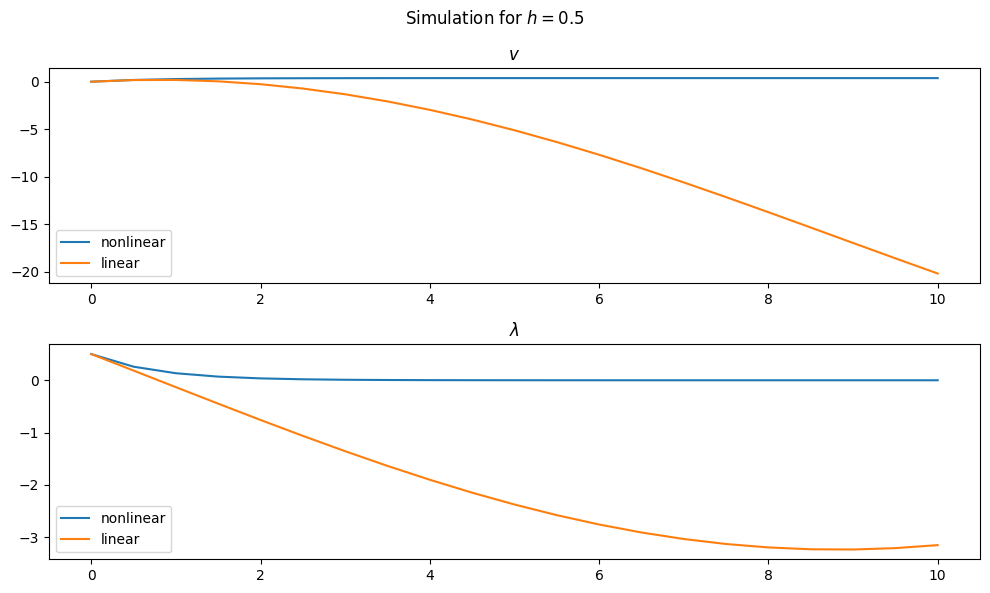

In [8]:
xhat = np.array([0.0, 0.0])
uhat = np.array([0.0, 0.0])
# TODO: ------------------------
# TODO: compute A and B matrices

x_hat = np.array([1, 0.5])
u_hat = np.array([0, 0])

# A, B using finite difference method
# A = jac_x_fd(x_hat, u_hat)
# B = jac_u_fd(x_hat, u_hat)

# A, B using Casadi
A = jac_x_casadi(x_hat, u_hat).toarray()
B = jac_u_casadi(x_hat, u_hat).toarray()

# TODO: ------------------------
h = 0.5
def linearized_dynamics(x, u):
    return rk4(f, x_hat, u_hat, h) + A @ (x-x_hat) + B @ (u-u_hat)

x0 = np.array([0.0, 0.5])
u0 = np.array([0.0, 0.2])
Tsim = 10
Nsim = int(Tsim / h)
x_nonlinear = np.zeros((Nsim + 1, 2))
x_nonlinear[0] = x0
x_linear = np.zeros((Nsim + 1, 2))
x_linear[0] = x0
t = np.linspace(0, Tsim, Nsim + 1)
for i in range(Nsim):
    # TODO: ---------------------------------------
    # TODO: simulate one step with each integrator
    x_nonlinear[i + 1] = rk4(f, x_nonlinear[i], u0, h)
    x_linear[i + 1] = linearized_dynamics(x_linear[i], u0)
    # TODO: ---------------------------------------

plt.figure(figsize=(10, 6))
plt.suptitle(rf"Simulation for $h = {h}$")

plt.subplot(2, 1, 1)
plt.title(r"$v$")
plt.plot(t, x_nonlinear[:, 0], label="nonlinear")
plt.plot(t, x_linear[:, 0], label="linear")
plt.legend()

plt.subplot(2, 1, 2)
plt.title(r"$\lambda$")
plt.plot(t, x_nonlinear[:, 1], label="nonlinear")
plt.plot(t, x_linear[:, 1], label="linear")
plt.legend()

plt.tight_layout()
plt.show()

## Problem 3: Nonlinear Model Predictive Control

Now that you know more about how to discretize the dynamics and how CasADi's symbolic differentiation works, you are ready to implement the NMPC controller.

To formulate the optimization problem in a simple way, we will need the `ca.Opti` class.
We recommend reading the [documentation](https://web.casadi.org/docs/#document-opti) to have a good overview of its capabilities.

You will find below some utility functions for generating a track and for plotting the NMPC predictions or the closed-loop trajectory.

In [9]:
def generate_track(track_type: str) -> dict[str, ca.Function]:
    s = ca.SX.sym("s")
    if track_type == "simple":
        pos = ca.Function(
            "pos",
            [s],
            [ca.vertcat(np.pi * ca.sin(2 * np.pi * s), ca.sin(4 * np.pi * s))],
        )
    elif track_type == "complex":
        wx = np.random.randn(3)
        wy = np.random.randn(3)
        pos = ca.Function(
            "pos",
            [s],
            [
                ca.vertcat(
                    wx[0] * ca.sin(2 * np.pi * s)
                    + wx[1] * ca.sin(4 * np.pi * s)
                    + wx[2] * ca.sin(6 * np.pi * s),
                    wy[0] * ca.sin(2 * np.pi * s)
                    + wy[1] * ca.sin(4 * np.pi * s)
                    + wy[2] * ca.sin(6 * np.pi * s),
                )
            ],
        )
    else:
        raise ValueError(f"Unknown track type: {track_type}")

    dpos = ca.jacobian(pos(s), s)
    ddpos = ca.jacobian(dpos, s)

    tangent = ca.Function("tangent", [s], [dpos / ca.norm_2(dpos)])
    normal = ca.Function(
        "normal", [s], [ca.vertcat(-dpos[1], dpos[0]) / ca.norm_2(dpos)]
    )

    curvature = ca.Function(
        "curvature",
        [s],
        [ca.fabs((dpos[0] * ddpos[1] - dpos[1] * ddpos[0]) / ca.norm_2(dpos) ** 3)],
    )

    maxspeed = ca.Function("maxspeed", [s], [1 / (1 + curvature(s))])
    spd = maxspeed(np.linspace(0, 1, 100000)).toarray()
    mx, mn = np.max(spd), np.min(spd)
    a = 0.9 / (mx - mn)
    b = 0.1 - a * mn
    maxspeed = ca.Function("maxspeed", [s], [a / (1 + curvature(s)) / mx + b])

    svals = np.linspace(0, 1, 100000)
    posvals = pos(svals.reshape(1, -1)).toarray()
    width = 0.05 * (np.max(posvals) - np.min(posvals))

    # compute arc length parametrization

    # lam is the arc length. We need a function lambda -> s
    # => 1. evaluate lam at different s values
    # => 2. Since the the sequences are monotonous the inverse mapping is trivial
    # => 3. Create a linear spline (using ca.interpolant)
    diffs = np.linalg.norm(np.diff(posvals, axis=1), axis=0)
    lams = np.insert(np.cumsum(diffs), 0, 0.0)
    lams = lams / lams[-1]  # normalized distance
    param = ca.interpolant("param", "bspline", [lams], svals)

    # convert all previous functions into functions of lam
    lam = ca.SX.sym("lam")

    return {
        # used for mpc
        "maxspeed": ca.Function("maxspeed", [s], [maxspeed(s)]),
        # used for plotting
        "param": param,
        "pos": ca.Function("pos", [lam], [pos(param(lam))]),
        "tangent": ca.Function("tangent", [lam], [tangent(param(lam))]),
        "normal": ca.Function("normal", [lam], [normal(param(lam))]),
        "curvature": ca.Function("curvature", [lam], [curvature(param(lam))]),
        "width": width,
    }
plt.rcParams['text.usetex'] = True

def plot_curves(
    track: dict[str, ca.Function],
    lam: np.ndarray,
    speed: np.ndarray,
    accel: np.ndarray,
    brake: np.ndarray,
    epsilon_speed: np.ndarray,
    title: str,
):
    t = h * np.arange(len(lam))
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(t, track["maxspeed"](lam), "k--", linewidth=2, label="max speed")
    plt.plot(t, lam, linewidth=2, label="lam")
    plt.plot(t, speed, linewidth=2, label="speed")
    plt.step(t, np.append(accel, accel[-1]), linewidth=2, label="accel", where="post")
    plt.step(t, -np.append(brake, brake[-1]), linewidth=2, label="brake", where="post")
    plt.fill_between(t, speed-epsilon_speed, speed, color="gray", alpha=0.5, label="speed margin")
    plt.legend()
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()


def plot_track( track: dict[str, ca.Function], lam: np.ndarray, lam_predictions: np.ndarray):
    # Generate track points for visualization
    lam_track = np.linspace(0, 1, 500)[None,:]
    track_pos = track["pos"](lam_track).toarray()
    track_maxspeed = track["maxspeed"](lam_track).toarray().flatten()
    
    def plot_at_timestep(k):
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot track with color indicating max speed
        scatter = ax.scatter(
            track_pos[0, :], 
            track_pos[1, :], 
            c=track_maxspeed, 
            cmap='RdYlGn', 
            s=20, 
            alpha=0.6,
            label='Track'
        )
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Max Speed', rotation=270, labelpad=20)
        
        # Plot current car position
        car_pos = track["pos"](lam[k]).toarray()
        ax.plot(car_pos[0], car_pos[1], 'bo', markersize=15, label='Car Position', zorder=5)
        
        # Plot NMPC predictions (white points)
        if k < lam_predictions.shape[1]:
            pred_positions = track["pos"](lam_predictions[:, k:k+1].T).toarray()
            ax.plot(pred_positions[0, :], pred_positions[1, :], 'wo', 
                   markersize=6, markeredgecolor='black', markeredgewidth=1,
                   label='NMPC Predictions', zorder=4)
            # Connect predictions with a line
            ax.plot(pred_positions[0, :], pred_positions[1, :], 'w--', 
                   linewidth=1.5, alpha=0.7, zorder=3)
        
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.set_title(f'Track Visualization - Time Step {k} (t = {k*h:.3f}s)')
        ax.legend(loc='upper right')
        ax.axis('equal')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Create interactive slider
    interact(plot_at_timestep, k=(0, len(lam)-1, 1))

In [10]:
N = 10
h = 0.025
track = generate_track("simple")
# track = generate_track("complex")

### Task 1

The NMPC we will implement is the following

$$
\begin{align*}
\min_{x_i, u_i, \epsilon_i} \quad & \sum_{k=0}^{N-1} \left(-10 v_k + 0.1 a_k^2 + 1000 b_k^2 + 10000 (\epsilon_k^2 + \epsilon_k) \right) - 10v_N+10000(\epsilon_N^2 + \epsilon_N) \\
\text{s.t.} \quad & x_0 = x_{init},\\
& x_{k+1} = f_d(x_k, u_k), \quad k=0,\ldots,N-1, \\
& v_k \leq \bar{v}(\lambda_k) + \epsilon_k, \quad k=0,\ldots,N,\\
& \epsilon_k \geq 0, \quad k=0,\ldots,N,\\
& 0 \leq a_k,b_k \leq 1, \quad k=0,\ldots,N-1,
\end{align*}
$$

Note the following:
- the cost function has a negative coefficient on the velocity to maximize it, and some small penalties on the acceleration and braking inputs to avoid aggressive maneuvers.
- the velocity upper bound is given by the function $\bar{v}$ that depends on the track. In the code you can access it using `track["maxspeed"](lam)` where `lam` is a CasADi symbolic variable or a numpy array. 
- this constraint is softened using a slack variable $\epsilon_k$ to ensure feasibility of the optimization problem at all times. A high penalty is added to the cost function to discourage the use of this slack variable.

Your task is to complete the `create_nmpc` function below by implementing the constraints of our NMPC problem.
A lot has been implemented for you, but we still encourage you to read the whole function and try to understand it.

Quickly test your implementation by looking at the open-loop prediction for a single initial state $x_{init}=(0,0)$.

In [11]:
def f_d_casadi(x, u):
    return rk4(f_casadi, x, u, h)


def create_nmpc():
    opti = ca.Opti()

    # decision variables
    X = opti.variable(2, N + 1)
    U = opti.variable(2, N)

    X0 = opti.parameter(2, 1)
    lam0 = X0[0]
    v0 = X0[1]

    lam = X[0, :]
    speed = X[1, :]
    accel = U[0, :]
    brake = U[1, :]

    epsilon_speed = opti.variable(1, N + 1)  # slack variable for speed constraint

    # objective function
    opti.minimize(
        # max velocity
        -10 * ca.sum(speed)
        # minimize acceleration
        + 0.1 * accel @ accel.T
        # minimize braking
        + 1000 * brake @ brake.T
        # L1 and L2 penalties on slack variables
        + 10000 * ((epsilon_speed @ epsilon_speed.T) + ca.sum(epsilon_speed))
    )

	# TODO: ---------------------------------------
    # TODO: initial conditions
    opti.subject_to(lam[0] == lam0)
    opti.subject_to(speed[0] == v0)

    # TODO: dynamics constraints (write the dynamics constraints as a function of X[:, k], U[:, k] and X[:, k + 1])
    for k in range(N):
        opti.subject_to(X[:, k+1] == f_d_casadi(X[:, k], U[:, k]))

    # TODO: velocity constraints
    opti.subject_to(speed <= track["maxspeed"](lam) + epsilon_speed)

    # TODO: input constraints
    opti.subject_to(0 <= ca.vec(U))
    opti.subject_to(ca.vec(U) <= 1)

    # TODO: slack variable constraints
    opti.subject_to(epsilon_speed >= 0) 
    # TODO: ---------------------------------------

    # set solver
    options = {
        "print_time": False,
        "ipopt": {"sb": "yes", "print_level": 0, "tol": 1e-3},
    }
    opti.solver("ipopt", options)

    return {
        # solver instance
        "opti": opti,
        # optimization variables
        "X": X,
        "U": U,
        "epsilon_speed": epsilon_speed,
        # optimization parameters
        "X0": X0,
        # convenience variables
        "lam": lam,
        "speed": speed,
        "accel": accel,
        "brake": brake,
        "lam0": lam0,
        "v0": v0,
    }

In [12]:
# set parameter values
nmpc = create_nmpc()
nmpc["opti"].set_value(nmpc["lam0"], 0.0)
nmpc["opti"].set_value(nmpc["v0"], 0.0)
# solve the problem
sol = nmpc["opti"].solve()

plot_curves(
    track,
    sol.value(nmpc["lam"]),
    sol.value(nmpc["speed"]),
    sol.value(nmpc["accel"]),
    sol.value(nmpc["brake"]),
    sol.value(nmpc["epsilon_speed"]),
    "Open loop prediction",
)

RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x0000027C7FB29580> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1000x600 with 1 Axes>

### Task 2

Now, you will test your controller in a closed-loop simulation around the racing track. Complete the code below to specify the current state, call the solver and extract the optimal control to apply to the system.

In the plots below you will see the evolution of each state and control throughout the simulation, as well as the position open-loop predictions of the NMPC at each time step.

If you go back a few cells and generate a 'complex' track, you should see that the velocity constraint is sometimes violated. Try tuning the cost function weights to reduce this effect.

In [ ]:
# closed loop simulation
states = [np.array([0.0, 0.0])]
controls = []
epsilon_speed = [0.0]
lam_predictions = []
i = 0
while states[-1][0] < 1:  # take one loop around the track
    i += 1

	# TODO: --------------------------------
    # TODO: update MPC params and solve it
    nmpc["opti"].set_value(...)
    sol = ...
    u_mpc = np.array(...)
    # TODO: --------------------------------

    # simulate next step and log values
    controls.append(u_mpc)
    states.append(f_d_casadi(states[-1], controls[-1]).toarray())
    epsilon_speed.append(sol.value(nmpc["epsilon_speed"][0]))
    lam_predictions.append(sol.value(nmpc["lam"]))

states = np.column_stack(states)
controls = np.column_stack(controls)
epsilon_speed = np.array(epsilon_speed)
lam_predictions = np.column_stack(lam_predictions)

In [ ]:
# plot closed loop results
plot_curves(
    track,
    states[0],
    states[1],
    controls[0],
    controls[1],
    epsilon_speed,
    "Closed loop simulation",
)
plot_track(track, states[0], lam_predictions)